<a href="https://colab.research.google.com/github/vaibhavmittal98/Beta-Estimation-using-Bayesian-Inference/blob/main/Retrieve_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install yfinance
!pip install -q gwpy

!pip uninstall matplotlib
!pip install matplotlib==3.1.3

     |████████████████████████████████| 6.4 MB 7.2 MB/s 
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
     |████████████████████████████████| 1.4 MB 5.2 MB/s 
     |████████████████████████████████| 51 kB 3.0 MB/s 
     |████████████████████████████████| 11.2 MB 49.2 MB/s 
     |████████████████████████████████| 890 kB 43.0 MB/s 
     |████████████████████████████████| 55 kB 1.3 MB/s 
     |████████████████████████████████| 3.6 MB 38.0 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.
Found existing installation: matplotlib 3.5.1
Uninstalling matplotlib-3.5.1:
  Would remove:


In [ ]:
import matplotlib.pyplot as plt
from scipy import stats
import pandas as pd
import numpy as np
import datetime as dt

import yfinance as yf

In [ ]:
# From 1972
spy_avg_hist_return = 0.11

In [ ]:


# Median value of the full market capitalization over 60 days after the 
# earnings publication on the reference date 
company_pv = 100000

# Take this value from balance sheets from the liability side
company_equity_ratio = 0.71
company_debt_ratio = 0.29

# Be careful as the company might be global so we cannot use
# the US tax rate so let's say for now 34%
company_tax_rate = 0.34

# take the yield of a rencent corporate common bond
# or a rating from S&P or Moody's
company_cost_of_debt = 0.04

# Take this info from the Income statement
# free cash flow per share msft from 2000-2010 
# sources:
#  https://seekingalpha.com/article/170773-microsoft-free-cash-flow-analysis
#  https://www.alphaquery.com/stock/MSFT/fundamentals/annual/free-cash-flow-per-share
company_cash_flows = [
                   0.9, 0.99, 1, 1.04, 1.05,
                   1.19, 1.18, 1.41, 1.81, 1.86,
                   2.87, 3.45, 2.9, 3.22, 2.87,
                   3.12, 4.01, 4.14, 4.93, 5.89
                   ]


# tm = (1 + g)/(wacc - g)
# wacc : is our r from accounting beta
# g is the perpetual growth let's use the standard 4%
# (Note: this should always be smaller than the economy growth rate)
g = 0.04
# wacc = company_equity_ratio * company_beta_accounting + company_debt_ratio * company_cost_of_debt * (1-company_tax_rate)
# company_terminal_multiple = (1 + g)/(wacc - g)



In [ ]:
def get_median_monthly_price(ticker_str: str,
                             date_start=dt.datetime(1999, 1, 1),
                             date_end=dt.datetime(2020, 12, 30)):

  ticker_company = yf.Ticker(ticker_str)
  df_h_company = ticker_company.history(start=date_start, end=date_end)
  df_h_company = df_h_company.reset_index()

  df_h_company['year'] = df_h_company['Date'].dt.year
  df_h_company['month'] = df_h_company['Date'].dt.month
  
  df_h_company = df_h_company.groupby(['year', 'month'])['Close'].median().reset_index()
  return df_h_company

df_h_company = get_median_monthly_price('MSFT')
df_h_spy = get_median_monthly_price('SPY')


def get_df_beta(df_h_company, df_h_spy):

  df_h = df_h_company.merge(df_h_spy, how='inner', on=['year', 'month'], suffixes=('_ntfx', '_spy'))

  df_h[['pct_change_ntfx', 'pct_change_spy']] = df_h[['Close_ntfx', 'Close_spy']].pct_change()
  df_h['Date'] = df_h[['year','month']].apply(lambda d: dt.datetime(d['year'], d['month'], 1), axis=1)

  df_cov = df_h.set_index('Date')[['pct_change_spy', 'pct_change_ntfx']].rolling(f'{5*365}D').cov()

  df_cov = df_cov.reset_index()

  df_cov = df_cov[df_cov['level_1'] == 'pct_change_spy']

  df_cov['beta_accounting'] = df_cov['pct_change_ntfx']/df_cov['pct_change_spy']
  df_cov['beta_accounting'] *= (df_cov['Date'] > dt.datetime(2004,1,1)).map({True:1, False:np.nan})

  df_beta = df_cov.groupby(df_cov['Date'].dt.year)[['beta_accounting']].mean().reset_index()
  df_beta = df_beta.rename(columns={'Date':'year'})

  return df_beta, df_cov

df_beta, df_cov = get_df_beta(df_h_company, df_h_spy)

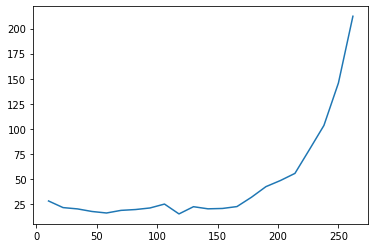

In [ ]:
df_h_company[df_h_company['month'] == 11]['Close'].plot()

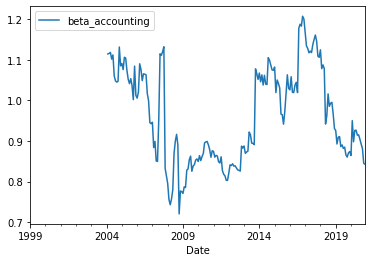

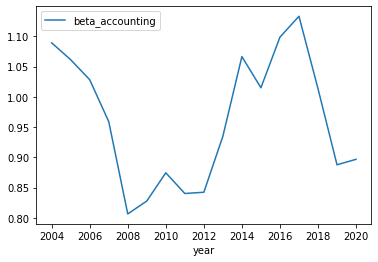

In [ ]:
ax = df_cov.set_index('Date')[['beta_accounting']].plot()
_ = df_beta.set_index('year')[['beta_accounting']].plot()

In [ ]:
##### INPUT ######

asof = 2010
beta = df_beta[df_beta['year'] == asof]['beta_accounting'].mean()
equity_risk_premium = spy_avg_hist_return
tax_rate = 0.34
# (Note: this should always be smaller than the economy growth rate)
g = 0.04

# Take this info from the Income statement
# free cash flow per share msft from 2000-2010 
# sources:
#  https://seekingalpha.com/article/170773-microsoft-free-cash-flow-analysis
#  https://www.alphaquery.com/stock/MSFT/fundamentals/annual/free-cash-flow-per-share
company_cash_flows = [
                   0.9, 0.99, 1, 1.04, 1.05,
                   1.19, 1.18, 1.41, 1.81, 1.86,
                   2.87, 3.45, 2.9, 3.22, 2.87,
                   3.12, 4.01, 4.14, 4.93, 5.89
                   ]

df_company = pd.DataFrame(np.arange(20)+2000, columns=['year'])
df_company['cf'] = pd.Series(company_cash_flows)

# Source : https://www.macrotrends.net/stocks/charts/MSFT/microsoft/debt-equity-ratio
df_company['equity_ratio'] = 457/(457+37) # 2010 values
df_company['debt_ratio'] = 1-df_company['equity_ratio']
# Source: https://www.businessinsider.com/microsoft-low-bond-yields-thirty-years?r=US&IR=T
df_company['cost_of_debt'] = 0.031       # corporate bond yield

###########################
df_company = df_company.merge(df_beta, on='year')
df_company.head()

,year,cf,equity_ratio,debt_ratio,cost_of_debt,beta_accounting
0,2000,0.90,0.925101,0.074899,0.031,NaN
1,2001,0.99,0.925101,0.074899,0.031,NaN
2,2002,1.00,0.925101,0.074899,0.031,NaN
3,2003,1.04,0.925101,0.074899,0.031,NaN
4,2004,1.05,0.925101,0.074899,0.031,1.089347


In [ ]:
def valuation_function(df_company, asof, beta=None,
                       equity_risk_premium=spy_avg_hist_return,
                       risk_free_rate=0.032, # TODO find right value per year: US T-Bonds 10y yield 
                       tax_rate=0.34, projected_cash_flow_years=5,
                       g=0.04, terminal_multiple=None): # g is the growth in perpetuity

  if beta is None:
    beta = df_company[df_company['year'] == asof]['beta_accounting'].mean()

  df_asof = df_company[df_company['year'] == asof]
  df_final = df_company[df_company['year'] == (asof + projected_cash_flow_years+1)]
  
  # TODO : fix cost of debt
  if 'cost_of_debt' not in df_asof:
    df_asof['cost_of_debt'] = company_cost_of_debt

  wacc = (df_asof['equity_ratio'].mean()*(risk_free_rate + beta*(equity_risk_premium - risk_free_rate)) 
          + df_asof['debt_ratio'].mean()*df_company['cost_of_debt'].mean()*(1-tax_rate))

  # print(wacc, g, df_asof['equity_ratio'].mean(), risk_free_rate , beta, equity_risk_premium , risk_free_rate, df_asof['debt_ratio'].mean(), df_company['cost_of_debt'].mean(),(1-tax_rate))

  if terminal_multiple is None:
    terminal_multiple = (1 + g)/(wacc - g)

  df = df_company[df_company['year'].between(asof+1, asof+projected_cash_flow_years)].copy()
  df['discount_rate'] = df['year'].map(lambda a: np.power((1+wacc), a-asof))
  df['discounted_cf'] = df['cf']/df['discount_rate']

  final_term = df_final['cf'].mean()*terminal_multiple/np.power(1+wacc, projected_cash_flow_years+1)

  return df['discounted_cf'].sum() + final_term, wacc, terminal_multiple

print(beta)
valuation_function(df_company, asof, beta)

0.8744306572912853


(56.821303858934456, 0.09423274333968655, 19.176606897533556)

In [ ]:
# valuation_function(df_company_final, 2000, 500)

In [ ]:
# print(df_company.set_index('year')['cf'].map(np.log10).diff().map(np.exp).std())
# df_company.set_index('year')['cf'].map(np.log10).diff().map(np.exp).plot()

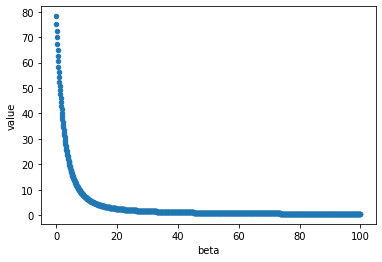

In [ ]:
df_tmp = pd.DataFrame(np.linspace(0,100, 1000), columns=['beta'])
df_tmp['value'] = df_tmp['beta'].map(lambda b: valuation_function(df_company, asof, b, terminal_multiple=19.18)[0])
df_tmp.plot.scatter(x='beta', y='value')

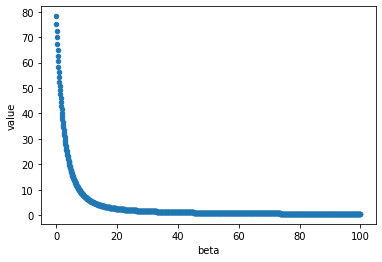

In [ ]:
df_tmp.plot.scatter(x='beta', y='value')

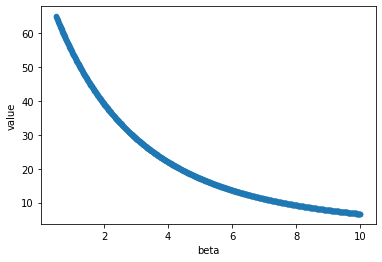

In [ ]:
df_tmp = pd.DataFrame(np.linspace(0.5,10, 1000), columns=['beta'])
df_tmp['value'] = df_tmp['beta'].map(lambda b: valuation_function(df_company, asof, b, terminal_multiple=19.18)[0])
df_tmp.plot.scatter(x='beta', y='value')

In [ ]:
def implied_beta(df_company, asof, real_value, terminal_multiple=None, beta_lower_limit=0, beta_upper_limit=10000, precision=0.01, verbose=False):
  beta = (beta_lower_limit + beta_upper_limit)/2
  estimated_value = valuation_function(df_company, asof, beta, terminal_multiple=terminal_multiple)[0]

  if verbose:
    print(beta, estimated_value)

  if estimated_value == np.nan:
    return np.nan

  estimation_ratio = estimated_value/real_value
  
  if estimation_ratio < (1-precision):
    return implied_beta(df_company, asof, real_value, terminal_multiple=terminal_multiple, beta_lower_limit=beta_lower_limit, beta_upper_limit=beta, verbose=verbose)
  elif estimation_ratio > (1+precision):
    return implied_beta(df_company, asof, real_value, terminal_multiple=terminal_multiple, beta_lower_limit=beta, beta_upper_limit=beta_upper_limit, verbose=verbose)
  else:
    return beta


terminal_multiple = valuation_function(df_company, asof, beta)[2]
print(terminal_multiple)
implied_beta(df_company, asof, real_value=30, terminal_multiple=terminal_multiple)

19.176606897533556


2.899169921875

In [ ]:
# implied_beta(df_company_final, 2000, 5.5e9, verbose=True)

In [ ]:
i_beta = implied_beta(df_company, asof, real_value=30)
valuation_function(df_company, asof, i_beta), i_beta

((30.2352754280124, 0.1384872722770907, 10.559740116205008), 1.48773193359375)

In [ ]:
i_beta = implied_beta(df_company, asof-5, real_value=30)
valuation_function(df_company, asof, i_beta), i_beta

((38.796311213605726, 0.1178427329961491, 13.360270894541292),
 1.201629638671875)

In [ ]:
df_company_final = df_company.copy()

df_company_final['estiamted_value'] = df_company_final['year'].map(lambda y: valuation_function(df_company_final, asof=y)[0])

df_company_final['real_value'] = df_company_final['year'].map(lambda y: 
            df_h_company[(df_h_company['month'] == 11) & (df_h_company['year'] == y)]['Close'].mean())
df_company_final['beta_implied'] = df_company_final[['year', 'real_value']].apply(lambda a: implied_beta(df_company_final, a['year'], a['real_value']), axis=1)
df_company_final['beta_implied_shifted'] = df_company_final['beta_implied'].shift(periods=5)

df_company_final
temp = pd.DataFrame(df_company_final, columns = ['year','beta_accounting'])
temp.to_csv('tempdata.csv')
from google.colab import files
files.download("tempdata.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
df_company_final

,year,cf,equity_ratio,debt_ratio,cost_of_debt,beta_accounting,estiamted_value,real_value,beta_implied,beta_implied_shifted
0,2000,0.90,0.925101,0.074899,0.031,NaN,NaN,21.760870,0.724792,NaN
1,2001,0.99,0.925101,0.074899,0.031,NaN,NaN,20.448509,0.858307,NaN
2,2002,1.00,0.925101,0.074899,0.031,NaN,NaN,17.882185,1.125336,NaN
3,2003,1.04,0.925101,0.074899,0.031,NaN,NaN,16.374825,1.258850,NaN
4,2004,1.05,0.925101,0.074899,0.031,1.089347,28.274674,18.991035,1.487732,NaN
5,2005,1.19,0.925101,0.074899,0.031,1.061384,35.178882,19.817703,1.640320,0.724792
6,2006,1.18,0.925101,0.074899,0.031,1.028364,33.456924,21.383768,1.487732,0.858307
7,2007,1.41,0.925101,0.074899,0.031,0.959072,40.756230,25.260767,1.430511,1.125336
8,2008,1.81,0.925101,0.074899,0.031,0.806438,47.168659,15.463294,2.212524,1.258850
9,2009,1.86,0.925101,0.074899,0.031,0.827747,49.753530,22.646314,1.678467,1.487732


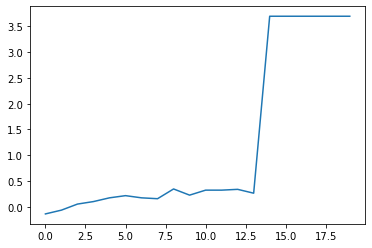

In [ ]:
df_company_final['beta_implied'].replace(5, np.nan).map(np.log10).plot()

In [ ]:
["amzn","msft","fb","tsla","aapl","goog","ibm","sony","csco","tsm","nvda","nok"]

['amzn',
 'msft',
 'fb',
 'tsla',
 'aapl',
 'goog',
 'ibm',
 'sony',
 'csco',
 'tsm',
 'nvda',
 'nok']

In [ ]:
def clean_df(ticker, csv_suffix):
  _df_ticker = pd.read_csv(f'{ticker}-{csv_suffix}')
  df_ticker = _df_ticker.set_index('Year').T
  df_ticker.columns.name=None
  df_ticker = df_ticker.sort_index()
  return df_ticker

def get_dfs(ticker):
  df_ratio = clean_df(ticker, 'ratios-annual.csv')
  df_cf = clean_df(ticker, 'cash_flow_statement-annual.csv')
  return df_ratio, df_cf
  

In [ ]:
%%capture
df_h_spy = get_median_monthly_price('SPY')
ticks = ["amzn","msft","fb","tsla","aapl","goog","ibm","sony","csco","tsm","nvda","nok"]
dict_df_companies = {}
for t in ticks:
  # Download and save .csv files
  !wget https://xamin.it/stock-bda/$t-ratios-annual.csv
  !wget https://xamin.it/stock-bda/$t-cash_flow_statement-annual.csv
  
  # Load and merge data frames
  df_ratio, df_cf = get_dfs(t)
  df = df_ratio.join(df_cf, how='inner')

  # Filter and add columns
  df = df[['Market Capitalization', 'Debt / Equity Ratio', 'Free Cash Flow']]
  df['debt_ratio'] = df['Debt / Equity Ratio'].map(lambda a: (a/(a+1)))
  df['equity_ratio'] = 1 - df['debt_ratio']
  df = df.drop(columns=['Debt / Equity Ratio'])
  df = df.rename(columns={'Market Capitalization':'mkt_cap', 'Free Cash Flow':'cf'})
  df['ticker'] = t
  df = df.reset_index().rename(columns={'index':'year'})
  df['year'] = df['year'].astype('int64')


  # Fill NaN - git blame => Vaibhav
  df = df.ffill()

  # Compute accounting beta
  df_h_company = get_median_monthly_price(t)
  df_beta = get_df_beta(df_h_company, df_h_spy)[0]
  df = df.merge(df_beta, how='left', on='year')

  dict_df_companies[t] = df

In [ ]:
df_h_spy = get_median_monthly_price('SPY')

def func_tmp(a):
  # print(a)
  return implied_beta(df_company_final, a['year'], a['mkt_cap'])

for t in ticks:
  try:
    df = dict_df_companies[t].copy()


    df_company_final = df[df['year'].between(1999, 2020)].copy()


    df_company_final['cost_of_debt'] = company_cost_of_debt
    df_company_final['estiamted_value'] = df_company_final['year'].map(lambda y: valuation_function(df_company_final, asof=y)[0])

    # df_company_final['stock_price'] = df_company_final['year'].map(lambda y: 
    #             df_h_company[(df_h_company['month'] == 11) & (df_h_company['year'] == y)]['Close'].mean())
    df_company_final['beta_implied'] = df_company_final[['year', 'mkt_cap']].apply(lambda a: func_tmp(a), axis=1)
    # df_company_final['beta_implied'] = df_company_final[['year', 'mkt_cap']].apply(lambda a: implied_beta(df_company_final, a['year'], a['real_value']), axis=1)
    df_company_final['beta_implied_shifted'] = df_company_final['beta_implied'].shift(periods=5)

    df =  df_company_final
    # break
  except:
    print(t)
    continue
df

amzn
msft
aapl
goog


,year,mkt_cap,cf,debt_ratio,equity_ratio,ticker,beta_accounting,cost_of_debt,estiamted_value,beta_implied,beta_implied_shifted
0,2001,1.162120e+11,5.917900e+09,0.078341,0.921659,nok,NaN,0.04,NaN,7.629395,NaN
1,2002,7.343172e+10,4.376750e+10,0.037536,0.962464,nok,NaN,0.04,NaN,14.343262,NaN
2,2003,8.139442e+10,7.834350e+10,0.031008,0.968992,nok,NaN,0.04,NaN,13.427734,NaN
3,2004,7.515790e+10,7.424110e+10,0.015748,0.984252,nok,1.724311,0.04,4.890406e+11,16.174316,NaN
4,2005,8.534683e+10,7.782720e+10,0.031008,0.968992,nok,1.650206,0.04,4.782029e+11,18.005371,NaN
5,2006,9.009657e+10,1.267790e+11,0.025341,0.974659,nok,1.615842,0.04,4.882996e+11,14.953613,7.629395
6,2007,1.572090e+11,9.982620e+10,0.068034,0.931966,nok,1.509336,0.04,6.181969e+11,7.934570,14.343262
7,2008,6.213187e+10,1.624660e+11,0.245852,0.754148,nok,1.414108,0.04,1.403913e+12,15.563965,13.427734
8,2009,4.884219e+10,7.220570e+10,0.293785,0.706215,nok,1.219990,0.04,3.505959e+12,18.310547,16.174316
9,2010,3.864795e+10,4.264710e+10,0.284692,0.715308,nok,1.240531,0.04,2.971794e+12,24.414062,18.005371


In [ ]:
def func_tmp(a):
  print(a)
  return implied_beta(df_company_final, a['year'], a['mkt_cap'])

implied_beta(df_company_final, 2000, 5.5e9)

df = dict_df_companies['amzn'].copy()


df_company_final = df[df['year'].between(1999, 2020)].copy()


# df_company_final['cost_of_debt'] = company_cost_of_debt
# df_company_final['estiamted_value'] = df_company_final['year'].map(lambda y: valuation_function(df_company_final, asof=y)[0])

# df_company_final['beta_implied'] = df_company_final[['year', 'mkt_cap']].apply(lambda a: func_tmp(a), axis=1)

df_company_final

In [ ]:
df_company_final


,year,mkt_cap,cf,debt_ratio,equity_ratio,ticker,beta_accounting,cost_of_debt,estiamted_value
2,1999,2.594414e+10,-3.779300e+08,0.847584,0.152416,amzn,NaN,0.04,NaN
3,2000,5.542061e+09,-2.652000e+08,1.821693,-0.821693,amzn,NaN,0.04,NaN
4,2001,4.022370e+09,-1.701030e+08,2.968504,-1.968504,amzn,NaN,0.04,NaN
5,2002,7.205883e+09,1.351280e+08,2.443001,-1.443001,amzn,NaN,0.04,NaN
6,2003,2.110459e+10,3.470000e+08,2.133787,-1.133787,amzn,NaN,0.04,NaN
7,2004,1.807262e+10,4.770000e+08,1.139431,-0.139431,amzn,1.521085,0.04,-7.389365e+10
8,2005,1.954238e+10,5.290000e+08,0.857469,0.142531,amzn,1.674402,0.04,2.932455e+11
9,2006,1.625446e+10,4.860000e+08,0.743129,0.256871,amzn,1.223178,0.04,3.303118e+10
10,2007,3.846203e+10,1.181000e+09,0.520384,0.479616,amzn,1.129690,0.04,5.229217e+10
11,2008,2.199053e+10,1.364000e+09,0.132697,0.867303,amzn,1.575243,0.04,1.677970e+10


In [ ]:
for t in ticks:
  df = dict_df_companies[t].copy().set_index('year')
  (df['cf']/df['mkt_cap']).plot(label=t)
  # break

plt.legend()

In [ ]:
df = dict_df_companies['amzn'].copy()
df_all = df[df['year'].between(1999, 2020)].copy()[['year']]

for t in ticks:
  df = dict_df_companies[t].copy()
  df = df[df['year'].between(1999, 2020)].copy()
  df[f'{t}_beta'] = df['beta_accounting']
  df_all = df_all.merge(df[[f'{t}_beta', 'year']], how='left', on='year')

df_all

,year,amzn_beta,msft_beta,fb_beta,tsla_beta,aapl_beta,goog_beta,ibm_beta,sony_beta,csco_beta,tsm_beta,nvda_beta,nok_beta
0,1999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,2004,1.521085,1.089348,NaN,NaN,1.472009,-2.874932,1.135990,1.119466,NaN,1.890853,2.705872,1.724311
6,2005,1.674402,1.061381,NaN,NaN,1.541625,1.797013,1.274654,1.160090,NaN,2.076280,2.571460,1.650206
7,2006,1.223178,1.028360,NaN,NaN,1.568103,2.329529,1.204523,1.156464,NaN,2.158420,3.091223,1.615842
8,2007,1.129690,0.959070,NaN,NaN,1.565738,1.658635,1.125791,0.954408,NaN,1.830989,3.161044,1.509336
9,2008,1.575243,0.806440,NaN,NaN,1.997838,1.755587,0.983754,1.283323,NaN,1.437018,3.203974,1.414108


In [ ]:
df_all = df_all[['year', 'amzn_beta', 'msft_beta', 'aapl_beta',
       'goog_beta', 'ibm_beta', 'sony_beta', 'tsm_beta',
       'nvda_beta', 'nok_beta']]

df_all = df_all.dropna(axis=0)

df_all

,year,amzn_beta,msft_beta,aapl_beta,goog_beta,ibm_beta,sony_beta,tsm_beta,nvda_beta,nok_beta
5,2004,1.521085,1.089348,1.472009,-2.874932,1.135990,1.119466,1.890853,2.705872,1.724311
6,2005,1.674402,1.061381,1.541625,1.797013,1.274654,1.160090,2.076280,2.571460,1.650206
7,2006,1.223178,1.028360,1.568103,2.329529,1.204523,1.156464,2.158420,3.091223,1.615842
8,2007,1.129690,0.959070,1.565738,1.658635,1.125791,0.954408,1.830989,3.161044,1.509336
9,2008,1.575243,0.806440,1.997838,1.755587,0.983754,1.283323,1.437018,3.203974,1.414108
10,2009,1.228054,0.827747,1.806522,1.325840,0.903775,1.322750,0.885985,1.985849,1.219990
11,2010,1.242427,0.874431,1.590078,1.209090,0.800157,1.341510,0.789522,1.713531,1.240531
12,2011,1.298193,0.840182,1.448191,1.157510,0.789721,1.325441,0.762889,1.766109,1.244937
13,2012,1.138855,0.842270,1.403941,1.144948,0.749890,1.350365,0.759257,1.623072,1.217915
14,2013,0.898601,0.934876,1.135023,1.124482,0.689675,1.547387,0.710344,1.368959,1.442073


In [ ]:
df_all.to_csv('all_betas.csv')